# ACGAN Model
[Conditional Image Synthesis with Auxiliary Classifier GANs paper](https://arxiv.org/pdf/1610.09585.pdf)

![Alt Text](images/acgan.jpg)


- CNN have brought advances in image classification
- CNN can also be reversed to generate images from scratch (generative models)
- One type of generative model are generative adversarial networks (GANs)
- Special type of GAN is Auxiliary Classifier GANs (ACGAN)
- GAN with class-label conditioning to generate images


## Example of Generated Images Conditioned on Label
![Alt Text](images/generated-images.png)


# Introduction to Generative Adversarial Networks (GANs)


![Alt Text](images/GANs.png)

- GAN is composed of two competing neural network models (often CNNs)
- **Generator: ** takes noise input and generate a realistic image
- **Discriminator: ** takes real and fake images and has to distinguish the fake from the real
- Two networks play an adversarial game
- generator learns to produce more and more realistic samples
- discriminator learns to get better and better at distinguishing generated data from real data.
- networks are trained simultaneously

** Training on real image: **
- Discriminator should classify real image as real
- Ouput probability close to 1

![Alt Text](images/Dis.png)

** Training on fake image: **
- Generator generate fake image from noise
- Discriminator should classify fake image as fake
- Ouput probability close to 0

![Alt Text](images/gen.png)





# Auxiliary Classifier ACGAN
Proposed a new method for improved training of GANs by conditioning input with class labels.

![Alt Text](images/acgan-2.png)


**Multi-input multi-output network:**
- **Inputs:** class embedding and noise vector
- **Outputs:** binary classifier (fake/real images) and multi-class classifier (image classes)

![Alt Text](images/acgan-3.png)

# Training and Evaluating ACGAN Model

# Imports

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import numpy as np
from collections import defaultdict
#import cPickle as pickle
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from six.moves import range
from glob import glob

In [2]:
models = tf.contrib.keras.models
layers = tf.contrib.keras.layers
utils = tf.contrib.keras.utils
losses = tf.contrib.keras.losses
optimizers = tf.contrib.keras.optimizers 
metrics = tf.contrib.keras.metrics
preprocessing_image = tf.contrib.keras.preprocessing.image
datasets = tf.contrib.keras.datasets

W0729 22:30:39.939763 140666660726528 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



# Construct Generator

In [3]:
def generator(latent_size, classes=10):
    
    def up_sampling_block(x, filter_size):
        x = layers.UpSampling2D(size=(2, 2))(x)
        x = layers.Conv2D(filter_size, (5,5), padding='same', activation='relu')(x)
        return x
    
    # Input 1
    # image class label
    image_class = layers.Input(shape=(1,), dtype='int32', name='image_class')
    
    # class embeddings
    emb = layers.Embedding(classes, latent_size,
                           embeddings_initializer='glorot_normal')(image_class)
    
    # 10 classes in MNIST
    cls = layers.Flatten()(emb)
    
    # Input 2
    # latent noise vector
    latent_input = layers.Input(shape=(latent_size,), name='latent_noise')
    
    # hadamard product between latent embedding and a class conditional embedding
    h = layers.multiply([latent_input, cls])
    
    # Conv generator
    x = layers.Dense(1024, activation='relu')(h)
    x = layers.Dense(128 * 7 * 7, activation='relu')(x)
    x = layers.Reshape((7, 7, 128))(x)
    
    # upsample to (14, 14, 128)
    x = up_sampling_block(x, 256)
    
    # upsample to (28, 28, 256)
    x = up_sampling_block(x, 128)
    
    # reduce channel into binary image (28, 28, 1)
    generated_img = layers.Conv2D(1, (2,2), padding='same', activation='tanh')(x)
    
    return models.Model(inputs=[latent_input, image_class],
                        outputs=generated_img,
                        name='generator') 

# Construct Discriminator

In [4]:
def discriminator(input_shape=(28, 28, 1)):
    
    def conv_block(x, filter_size, stride):
        x = layers.Conv2D(filter_size, (3,3), padding='same', strides=stride)(x)
        x = layers.LeakyReLU()(x)
        x = layers.Dropout(0.3)(x)
        return x
    
    input_img = layers.Input(shape=input_shape)
    
    x = conv_block(input_img, 32, (2,2))
    x = conv_block(x, 64, (1,1))
    x = conv_block(x, 128, (2,2))
    x = conv_block(x, 256, (1,1))
    
    features = layers.Flatten()(x)
    
    # binary classifier, image fake or real
    fake = layers.Dense(1, activation='sigmoid', name='generation')(features)
    
    # multi-class classifier, image digit class
    aux = layers.Dense(10, activation='softmax', name='auxiliary')(features)
    
    
    return models.Model(inputs=input_img, outputs=[fake, aux], name='discriminator')

# Combine Generator with Discriminator

In [5]:
# Adam parameters suggested in paper
adam_lr = 0.0002
adam_beta_1 = 0.5

def ACGAN(latent_size = 100):
    # build the discriminator
    dis = discriminator()
    dis.compile(
        optimizer=optimizers.Adam(lr=adam_lr, beta_1=adam_beta_1),
        loss=['binary_crossentropy', 'sparse_categorical_crossentropy']
    )

    # build the generator
    gen = generator(latent_size)
    gen.compile(optimizer=optimizers.Adam(lr=adam_lr, beta_1=adam_beta_1),
                      loss='binary_crossentropy')

    # Inputs
    latent = layers.Input(shape=(latent_size, ), name='latent_noise')
    image_class = layers.Input(shape=(1,), dtype='int32', name='image_class')

    # Get a fake image
    fake_img = gen([latent, image_class])

    # Only train generator in combined model
    dis.trainable = False
    fake, aux = dis(fake_img)
    combined = models.Model(inputs=[latent, image_class],
                            outputs=[fake, aux],
                            name='ACGAN')

    combined.compile(
        optimizer=optimizers.Adam(lr=adam_lr, beta_1=adam_beta_1),
        loss=['binary_crossentropy', 'sparse_categorical_crossentropy']
    )
    
    return combined, dis, gen

print("done")

done


# Load and Normalize MNIST Dataset

In [6]:
# reshape to (..., 28, 28, 1)
# normalize dataset with range [-1, 1]
(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()

# normalize and reshape train set
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=-1)

# normalize and reshape test set
X_test = (X_test.astype(np.float32) - 127.5) / 127.5
X_test = np.expand_dims(X_test, axis=-1)

nb_train, nb_test = X_train.shape[0], X_test.shape[0]

11493376/11490434 [==============================] - 0s 0us/step


# Training Helper Functions

In [7]:
def print_logs(metrics_names, train_history, test_history):

    print('{0:<22s} | {1:4s} | {2:15s} | {3:5s}'.format(
        'component', *metrics_names))
    print('-' * 65)

    ROW_FMT = '{0:<22s} | {1:<4.2f} | {2:<15.2f} | {3:<5.2f}'
    print(ROW_FMT.format('generator (train)',
                         *train_history['generator'][-1]))
    print(ROW_FMT.format('generator (test)',
                         *test_history['generator'][-1]))
    print(ROW_FMT.format('discriminator (train)',
                         *train_history['discriminator'][-1]))
    print(ROW_FMT.format('discriminator (test)',
                         *test_history['discriminator'][-1]))
    
def generate_batch_noise_and_labels(batch_size, latent_size):

    # generate a new batch of noise
    noise = np.random.uniform(-1, 1, (batch_size, latent_size))

    # sample some labels
    sampled_labels = np.random.randint(0, 10, batch_size)

    return noise, sampled_labels

# Train and Evaluate ACGAN on MNIST

In [10]:
nb_epochs = 50
batch_size = 100
latent_size = 100


train_history = defaultdict(list)
test_history = defaultdict(list)

combined, dis, gen = ACGAN(latent_size = 100)

for epoch in range(nb_epochs):
    print('Epoch {} of {}'.format(epoch + 1, nb_epochs))

    nb_batches = int(X_train.shape[0] / batch_size)
    progress_bar = utils.Progbar(target=nb_batches)

    epoch_gen_loss = []
    epoch_disc_loss = []

    for index in range(nb_batches):
        progress_bar.update(index)
        
        ### Train Discriminator ###
        
        # generate noise and labels
        noise, sampled_labels = generate_batch_noise_and_labels(batch_size, latent_size=100)
        
        # generate a batch of fake images, using the generated labels as a conditioner
        generated_images = gen.predict([noise, sampled_labels.reshape((-1, 1))], verbose=0)

        # get a batch of real images
        image_batch = X_train[index * batch_size:(index + 1) * batch_size]
        label_batch = y_train[index * batch_size:(index + 1) * batch_size]

        # construct discriminator dataset
        X = np.concatenate((image_batch, generated_images))
        y = np.array([1] * batch_size + [0] * batch_size)
        aux_y = np.concatenate((label_batch, sampled_labels), axis=0)

        # train discriminator
        epoch_disc_loss.append(dis.train_on_batch(X, [y, aux_y]))

        ### Train Generator ###
        
        # generate 2 * batch size here such that we have
        # the generator optimize over an identical number of images as the
        # discriminator       
        noise, sampled_labels = generate_batch_noise_and_labels(2 * batch_size, latent_size=100)

        # we want to train the generator to trick the discriminator
        # so all the labels should be not-fake (1)
        trick = np.ones(2 * batch_size)

        epoch_gen_loss.append(combined.train_on_batch(
            [noise, sampled_labels.reshape((-1, 1))], [trick, sampled_labels]))

    print('\nTesting for epoch {}:'.format(epoch + 1))

    ### Evaluate Discriminator ###

    # generate a new batch of noise
    noise, sampled_labels = generate_batch_noise_and_labels(nb_test, latent_size=100)

    # generate images
    generated_images = gen.predict(
        [noise, sampled_labels.reshape((-1, 1))], verbose=False)

    # construct discriminator evaluation dataset
    X = np.concatenate((X_test, generated_images))
    y = np.array([1] * nb_test + [0] * nb_test)
    aux_y = np.concatenate((y_test, sampled_labels), axis=0)

    # evaluate discriminator
    # test loss
    discriminator_test_loss = dis.evaluate(X, [y, aux_y], verbose=False)
    # train loss
    discriminator_train_loss = np.mean(np.array(epoch_disc_loss), axis=0)
    
    ### Evaluate Generator ###

    # make new noise
    noise, sampled_labels = generate_batch_noise_and_labels(2 * nb_test, latent_size=100)

    # create labels
    trick = np.ones(2 * nb_test)

    # evaluate generator
    # test loss
    generator_test_loss = combined.evaluate(
        [noise, sampled_labels.reshape((-1, 1))],
        [trick, sampled_labels], verbose=False)

    # train loss
    generator_train_loss = np.mean(np.array(epoch_gen_loss), axis=0)

    ### Save Losses per Epoch ###
    
    # append train losses
    train_history['generator'].append(generator_train_loss)
    train_history['discriminator'].append(discriminator_train_loss)

    # append test losses
    test_history['generator'].append(generator_test_loss)
    test_history['discriminator'].append(discriminator_test_loss)
    
    # print training and test losses
    print_logs(dis.metrics_names, train_history, test_history)
    
    # save weights every epoch
    gen.save_weights(
        'logs/params_generator_epoch_{0:03d}.hdf5'.format(epoch), True)
    dis.save_weights(
        'logs/params_discriminator_epoch_{0:03d}.hdf5'.format(epoch), True)

# Save train test loss history
pickle.dump({'train': train_history, 'test': test_history},
            open('logs/acgan-history.pkl', 'wb'))

Epoch 1 of 50
  0/600 [..............................] - ETA: 0s

W0729 22:39:31.296912 140666660726528 training.py:2197] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


599/600 [============================>.] - ETA: 0s
Testing for epoch 1:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 7.52 | 5.18            | 2.34 
generator (test)       | 8.16 | 5.85            | 2.31 
discriminator (train)  | 1.50 | 0.08            | 1.42 
discriminator (test)   | 1.26 | 0.00            | 1.26 
Epoch 2 of 50
599/600 [============================>.] - ETA: 0s
Testing for epoch 2:
component              | loss | generation_loss | auxiliary_loss
-----------------------------------------------------------------
generator (train)      | 8.30 | 6.41            | 1.89 
generator (test)       | 8.16 | 6.50            | 1.66 
discriminator (train)  | 1.05 | 0.00            | 1.05 
discriminator (test)   | 0.89 | 0.00            | 0.89 
Epoch 3 of 50
599/600 [============================>.] - ETA: 0s
Testing for epoch 3:
component              | loss | generation_los

# Generator Loss History

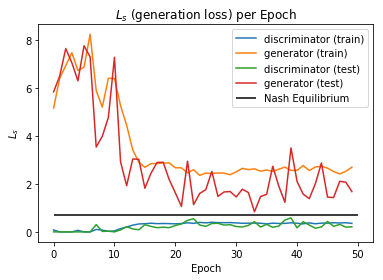

In [22]:
hist = pickle.load(open('logs/acgan-history.pkl','rb'))

for p in ['train', 'test']:
    for g in ['discriminator', 'generator']:
        hist[p][g] = pd.DataFrame(hist[p][g], columns=['loss', 'generation_loss', 'auxiliary_loss'])
        plt.plot(hist[p][g]['generation_loss'], label='{} ({})'.format(g, p))

# get the NE and show as an equilibrium point
plt.hlines(-np.log(0.5), 0, hist[p][g]['generation_loss'].shape[0], label='Nash Equilibrium')
plt.legend()
plt.title(r'$L_s$ (generation loss) per Epoch')
plt.xlabel('Epoch')
plt.ylabel(r'$L_s$')
plt.show()

# Label Classification Loss History

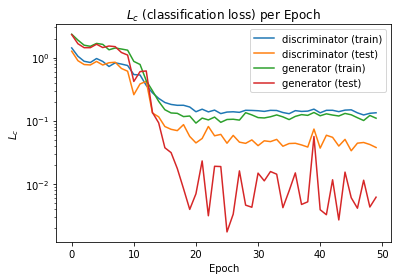

In [23]:
for g in ['discriminator', 'generator']:
    for p in ['train', 'test']:
        plt.plot(hist[p][g]['auxiliary_loss'], label='{} ({})'.format(g, p))

plt.legend()
plt.title(r'$L_c$ (classification loss) per Epoch')
plt.xlabel('Epoch')
plt.ylabel(r'$L_c$')
plt.semilogy()
plt.show()

# Generate Digits Conditioned on Class Label

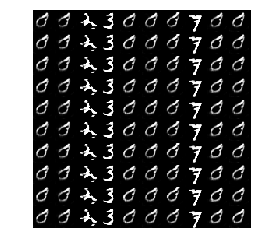

In [24]:
# load the weights from the last epoch
gen.load_weights(sorted(glob('logs/params_generator*'))[-1])

# construct batch of noise and labels
noise = np.tile(np.random.uniform(-1, 1, (10, latent_size)), (10, 1))
sampled_labels = np.array([[i] * 10 for i in range(10)]).reshape(-1, 1)

# generate digits
generated_images = gen.predict([noise, sampled_labels], verbose=0)

# arrange them into a grid and un-normalize the pixels
img = (np.concatenate([r.reshape(-1, 28)
                       for r in np.split(generated_images, 10)
                       ], axis=-1) * 127.5 + 127.5).astype(np.uint8)

# plot images
plt.imshow(img, cmap='gray')
_ = plt.axis('off')